In [390]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler #samples randomly from given indices
from torch.utils.data.dataloader import DataLoader # loads the data from sampler

warnings.filterwarnings('ignore')

In [391]:
# for reproducibility
torch.manual_seed(0)

In [392]:
# Defining transform to resize 1024x1024 to 128x128
# To change to Tensor
train_transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])
test_transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])

In [393]:
test_path = "../Datasets/Covid19-dataset/test/"
train_val_path="../Datasets/Covid19-dataset/train/"

dataset=ImageFolder(train_val_path,transform=train_transform)
test_dataset=ImageFolder(test_path,transform=test_transform)

In [394]:
# Checking For Samples
# img0,label0=dataset[10]
# print(img0.shape,label0)
# # img1,label1=dataset[300]
# # print(img1.shape,label1)
# print("*"*60)
# print(dataset.classes)#list out all the classes

In [395]:
# def show(img,label):
#   print("label-->",dataset.classes[label])
#   plt.imshow(img.permute(1,2,0))

# show(*dataset[144])
# 0-->Covid-19;1-->Normal

In [396]:
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  # Here indices are randomly permuted 
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
val_per=0.5
train_indices,validation_indices=split_train_val(len(dataset),val_per,randomness)
print(validation_indices[:5])

[207  31  48  52 245]


In [397]:
batch_size=16
# Training Part
train_sampler=SubsetRandomSampler(train_indices)
train_ds=DataLoader(dataset,batch_size,sampler=train_sampler)

# Validation Part
val_sampler=SubsetRandomSampler(validation_indices)
val_ds=DataLoader(dataset,batch_size,sampler=val_sampler)

In [398]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3)
    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3)
    self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3)
    self.conv4=nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
    self.conv5=nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3)
    # self.conv6=nn.Conv2d(in_channels=8,out_channels=3,kernel_size=3)
    # self.fc1=nn.Linear(in_features=8*31*31,out_features=32)
    self.fc1=nn.Linear(in_features=8*27*27,out_features=32)
    self.out=nn.Linear(in_features=32,out_features=3)

  def forward(self,l):
    l=self.conv1(l)
    l=self.conv2(l)
    l=self.conv3(l)
    l=self.conv4(l)
    l=self.conv5(l)
    # l=self.conv6(l)
    l=F.relu(l)
    l=F.max_pool2d(l,kernel_size=2)
    # print(l.size())
    # l=l.reshape( -1,8*31*31)
    l=l.view( -1,8*27*27)
    l=self.fc1(l)
    l=self.out(l)
    
    return l

In [399]:
model=ConvNet()

In [400]:
# # If gpu present then use it or else use cpu
# # if gpu not present dont run this cell
# def default_device():
    
#     if torch.cuda.is_available():
#         return torch.device("cuda:0")
#     else:
#         return torch.device("cpu")

# # device=default_device()
# device=torch.device("cpu")
# print(device)

In [401]:
# model.to(device)
model

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5832, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
)

In [402]:
loss_type = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

Epoch: 0 Running Loss: 426629.84639918804  Accuracy: 42.06349182128906
Epoch: 1 Running Loss: 64836.203753352165  Accuracy: 22.22222137451172
Epoch: 2 Running Loss: 13.498910427093506  Accuracy: 30.952381134033203
Epoch: 3 Running Loss: 11.237679600715637  Accuracy: 42.06349182128906
Epoch: 4 Running Loss: 8.997650265693665  Accuracy: 37.30158615112305
Epoch: 5 Running Loss: 9.272973477840424  Accuracy: 26.984127044677734
Epoch: 6 Running Loss: 9.001324653625488  Accuracy: 42.06349182128906
Epoch: 7 Running Loss: 8.697757482528687  Accuracy: 42.06349182128906
Epoch: 8 Running Loss: 8.838252186775208  Accuracy: 30.158729553222656
Epoch: 9 Running Loss: 8.755673468112946  Accuracy: 42.06349182128906
Epoch: 10 Running Loss: 8.733115673065186  Accuracy: 42.06349182128906
Epoch: 11 Running Loss: 8.651498436927795  Accuracy: 42.06349182128906


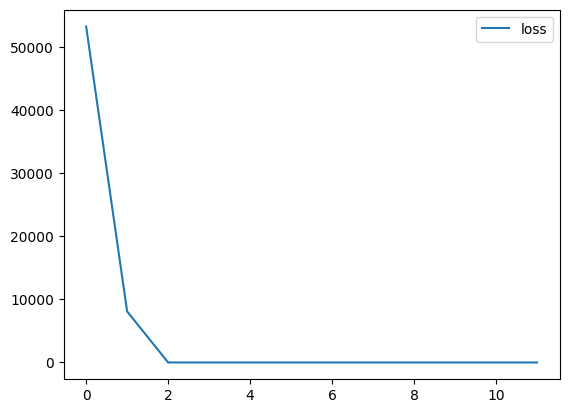

In [403]:

loss_val=[]
acc=[]
for epoch in range(12):  
# loop over the dataset multiple times
    # print("Epoch count-->",epoch)
    running_loss=0.0
    right = 0
    total = 0
    for i, data in enumerate(train_ds):
        inputs, labels = data
        # inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # Passing input into the model
        outputs = model(inputs)        
        # Caculating loss with crossentropy
        loss = loss_type(outputs, labels)
        # calculates the gradient 
        loss.backward()
        # update the weights
        optimizer.step()
        
        running_loss=running_loss+loss.item()
        _, predicted = torch.max(outputs,dim=1)
        total += labels.size(0)
        # Caculating number of right prediction
        right += (predicted == labels).sum()
        # running_loss=running_loss+loss.item()* inputs.size(0)
    print("Epoch:",epoch,"Running Loss:",running_loss," Accuracy:",(100 * right / total).item())
    loss_val.append(running_loss / len(train_ds))
    acc.append((100 * right / total).item())
plt.plot(loss_val,label="loss")
plt.legend()

In [404]:
right = 0
total = 0

with torch.no_grad():
# Switching off the gradient part, so that backpropagation doesnt take place
    for data in val_ds:
        images, labels = data
        #images,labels=images,labels
        # inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs,dim=1)
        total += labels.size(0)
        # Caculating number of right prediction
        right += (predicted == labels).sum()
        
print('Accuracy on the validation images: %d %%' % (100 * right / total))

Accuracy on the validation images: 46 %


In [405]:
batch_size=32
# Training Part
test_ds=DataLoader(test_dataset,batch_size)

In [406]:
right_test = 0
total_test = 0
with torch.no_grad():
    for data in test_ds:
        images, labels_test = data
        # images,labels_test=images.to(device),labels_test.to(device)
        #images,labels_test=images,labels_test
        outputs_test = model(images)
        _, predicted_test = torch.max(outputs_test, 1)
        total_test += labels_test.size(0)
        right_test += (predicted_test == labels_test).sum()

print('Accuracy on the Test images: %d %%' % (
    100 * right_test / total_test))

Accuracy on the Test images: 39 %
